In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.linear_model import  LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline



In [2]:
df = pd.read_csv("winequality.csv")
print(df.head())
print(df.info())

    type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.4

In [3]:
print(df.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6487.000000       6489.000000  6494.000000     6495.000000   
mean        7.216579          0.339691     0.318722        5.444326   
std         1.296750          0.164649     0.145265        4.758125   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6495.000000          6497.000000           6497.000000  6497.000000   
mean      0.056042            30.525319            115.744574     0.994697   
std       0.035036            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

In [4]:
print(df.isnull().sum())

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64


In [5]:
for col, value in df.items():
    if col != 'type':
        df[col] = df[col].fillna(df[col].mean())

In [6]:
df.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

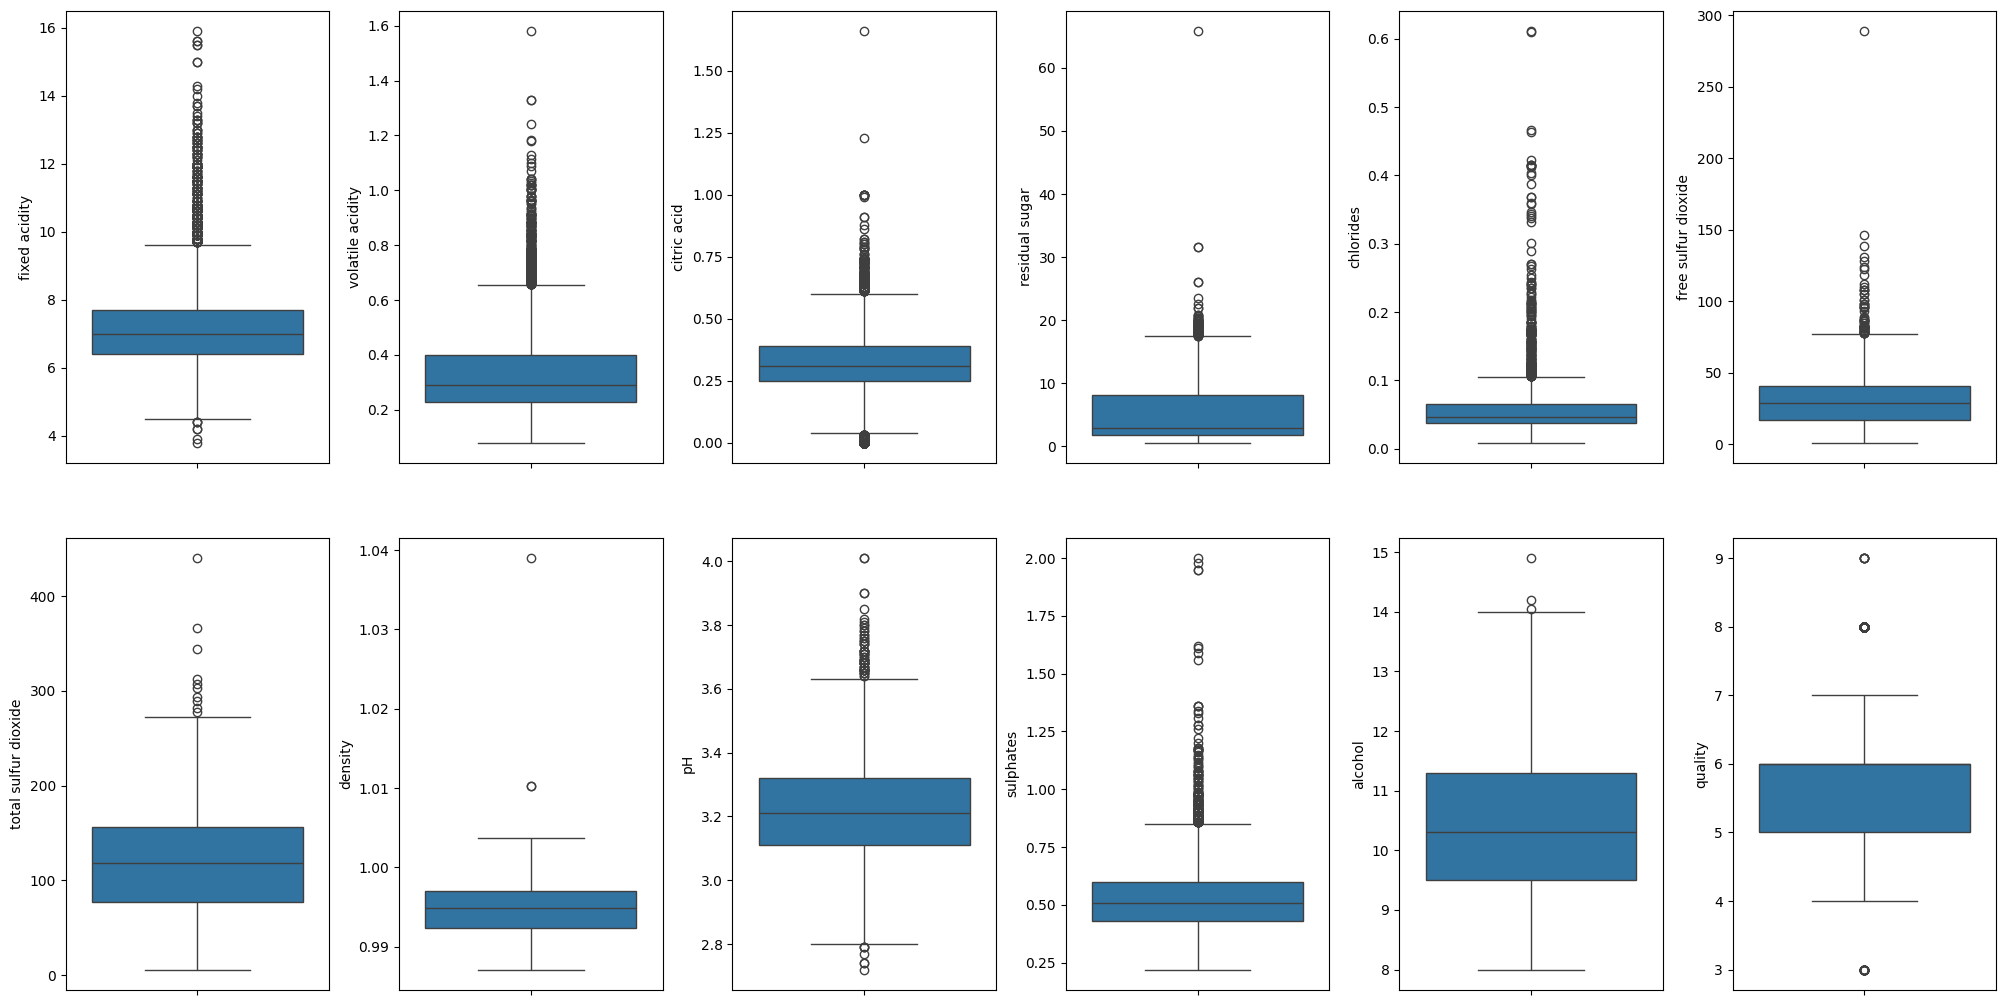

In [7]:
fig, ax = plt.subplots(ncols = 6, nrows = 2 , figsize = (20,10))
index = 0
ax = ax.flatten()

for col, value in df.items():
    if col != 'type':
        sns.boxplot(y=col, data = df, ax = ax[index])
        index +=1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

In [ ]:
# Copy original data (excluding non-numeric columns)
df_z = df.select_dtypes(include=[np.number]).copy()

# Compute z-scores
z_scores = np.abs(zscore(df_z))

# Define threshold
threshold = 3

# Replace outliers with upper/lower limits
for i, col in enumerate(df_z.columns):
    col_mean = df_z[col].mean()
    col_std = df_z[col].std()
    upper_limit = col_mean + threshold * col_std
    lower_limit = col_mean - threshold * col_std

    df_z[col] = np.where(z_scores[:, i] > threshold,
                         np.where(df_z[col] > upper_limit, upper_limit, lower_limit),
                         df_z[col])

print("✅ Outliers handled using Z-score method.")


✅ Outliers handled using Z-score method.


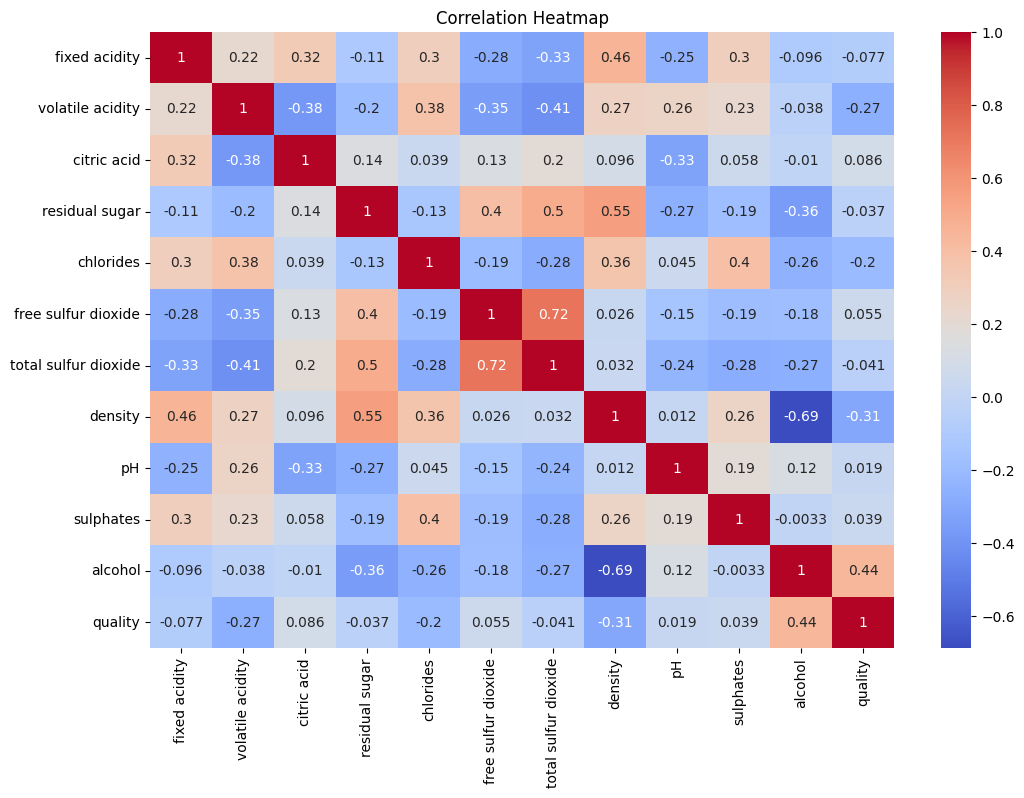

In [9]:
plt.figure(figsize =(12,8))
sns.heatmap(df.corr(numeric_only = True),annot = True, cmap ='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


/var/folders/vt/y6d48g2s7cg7csds0384wh400000gn/T/ipykernel_10658/4276231583.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(value, ax=ax[index])
/var/folders/vt/y6d48g2s7cg7csds0384wh400000gn/T/ipykernel_10658/4276231583.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(value, ax=ax[index]

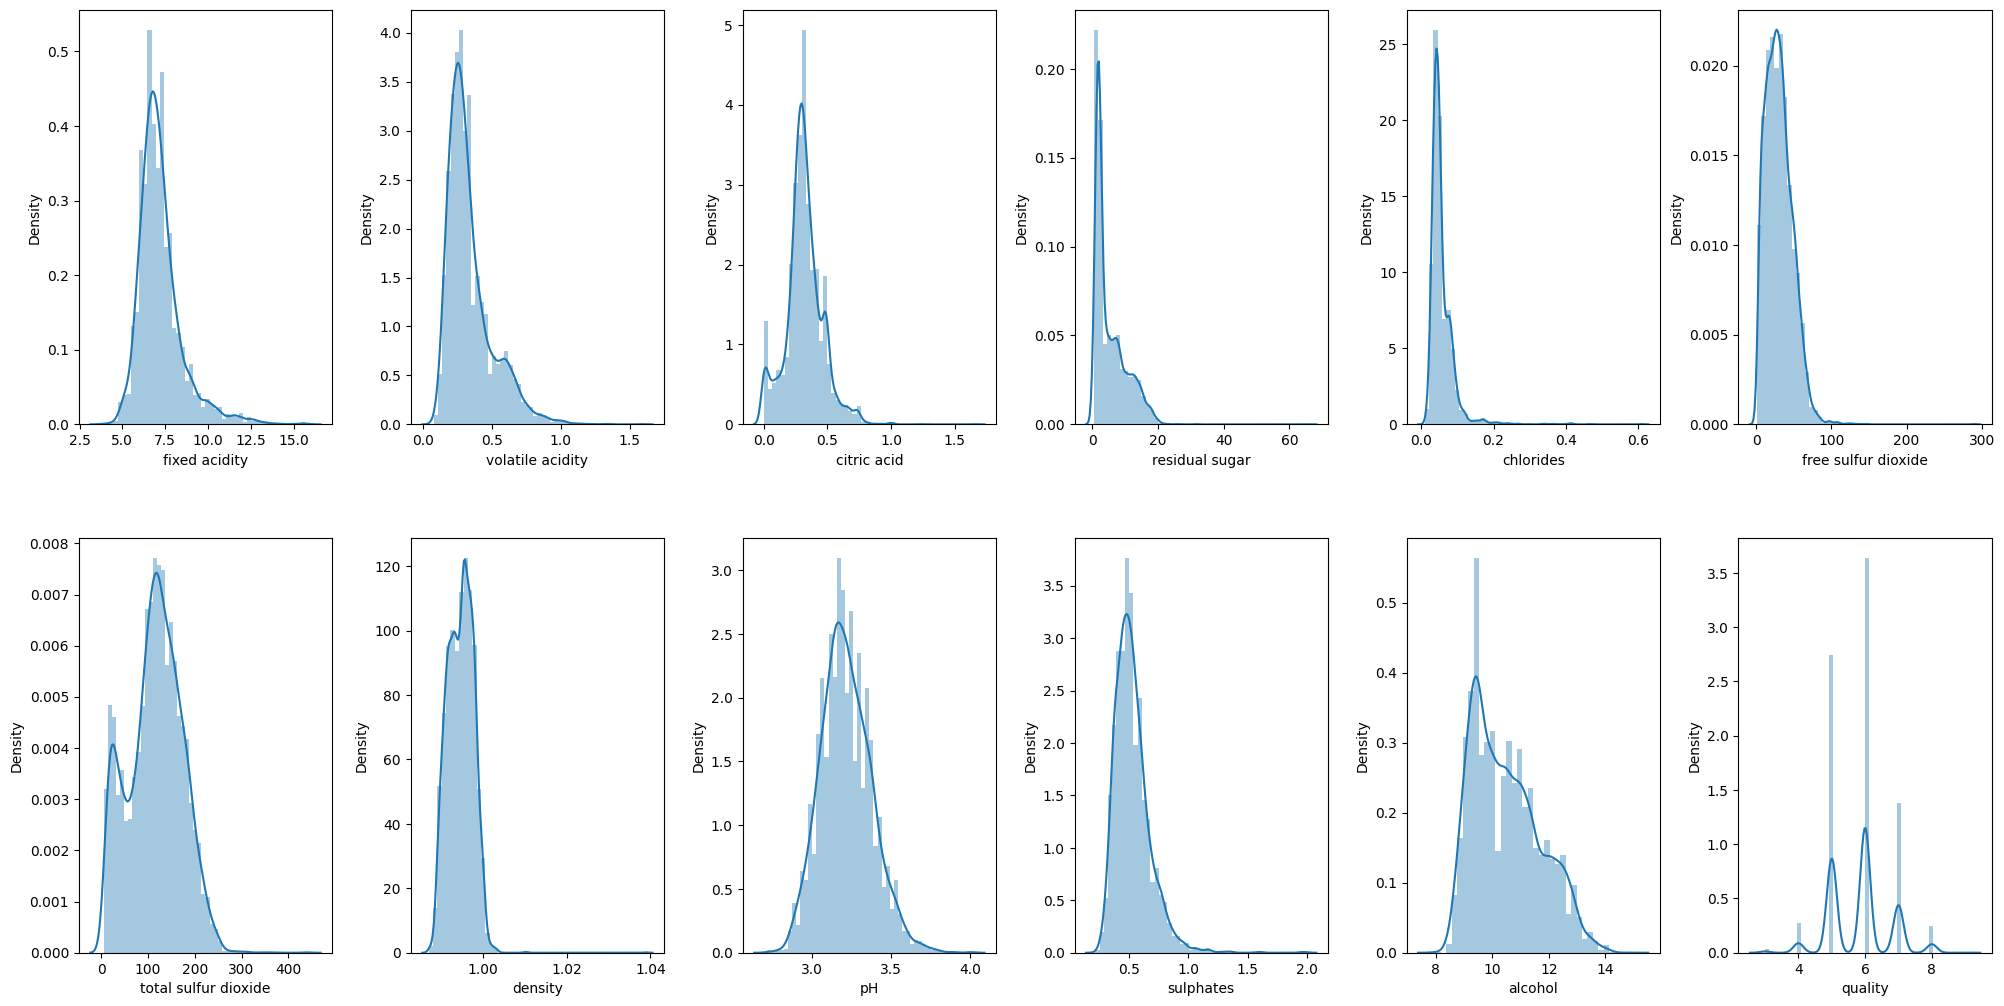

In [10]:
fig, ax = plt.subplots(ncols = 6, nrows = 2 , figsize = (20,10))
index = 0
ax = ax.flatten()

for col, value in df.items():
    if col != 'type':
        sns.distplot(value, ax=ax[index])
        index +=1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

In [11]:
X = df.drop(columns =['type','quality'])
y = df['quality']

In [12]:
y.value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

In [13]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=4)
# transform the dataset
X, y = oversample.fit_resample(X, y)

In [14]:
y.value_counts()

quality
6    2836
5    2836
7    2836
8    2836
4    2836
3    2836
9    2836
Name: count, dtype: int64

In [ ]:
df.replace([np.inf,-np.inf],np.nan,inplace = True)
df.dropna(inplace=True)
df.columns = df.columns.str.strip()

if 'type' in df.columns:
    df = pd.get_dummies(df, columns=['type'], drop_first=True)

X_simple = df[['free sulfur dioxide']]  
X_multi = df[['free sulfur dioxide','type_white']]
y = df['total sulfur dioxide'] 

In [16]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X_simple, y, test_size=0.25, random_state=42)

# Train model
model_simple = LinearRegression()
model_simple.fit(x_train, y_train)
y_pred = model_simple.predict(x_test)

# Evaluation metrics
mse_simple = mean_squared_error(y_test, y_pred)
rmse_simple = np.sqrt(mse_simple)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print("📘 Simple Linear Regression on 'residual sugar'")
print(f"R² Score      : {r2:.4f}")
print(f"MSE           : {mse_simple:.4f}")
print(f"RMSE          : {rmse_simple:.4f}")
print(f"MAE           : {mae:.4f}")
print(f"MAPE          : {mape * 100:.2f}%")


📘 Simple Linear Regression on 'residual sugar'
R² Score      : 0.5144
MSE           : 1530.5252
RMSE          : 39.1219
MAE           : 30.9714
MAPE          : 50.51%


/var/folders/vt/y6d48g2s7cg7csds0384wh400000gn/T/ipykernel_10658/1460657558.py:9: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/siddhu/Desktop/Programs/Machine Learning/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


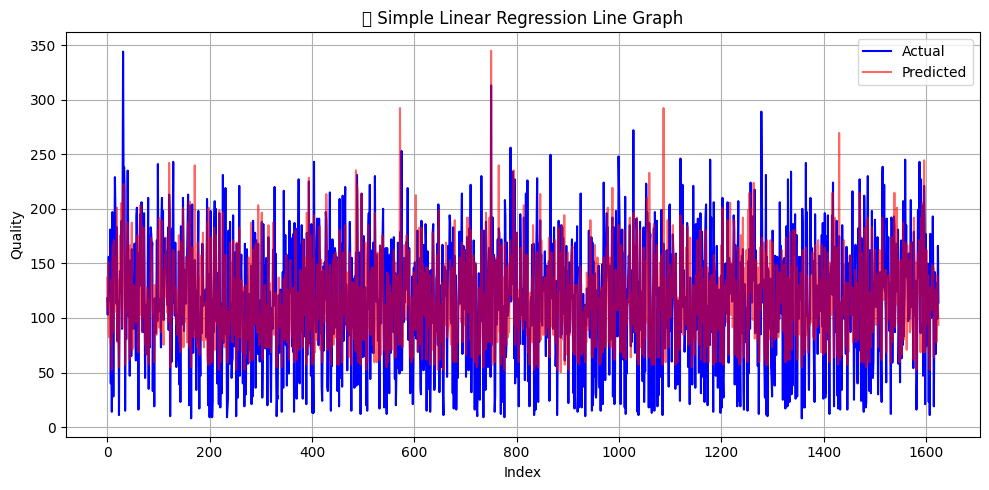

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(y_test)), y_test.values, color='blue', label='Actual')
plt.plot(np.arange(len(y_test)), y_pred, color='red', alpha=0.6, label='Predicted')
plt.title("🔍 Simple Linear Regression Line Graph")
plt.xlabel("Index")
plt.ylabel("Quality")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
x_train, x_test, y_train, y_test = train_test_split(X_multi, y, test_size=0.25, random_state=42)

model_multi = LinearRegression()
model_multi.fit(x_train, y_train)
y_pred = model_multi.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📘 Multiple Linear Regression")
print(f"R² Score: {r2:.4f}")
print(f"MSE     : {mse:.4f}")
print(f"RMSE    : {rmse:.4f}")
print(f"MAE     : {mae:.4f}")
print(f"MAPE    : {mape * 100:.2f}%")

📘 Multiple Linear Regression
R² Score: 0.6692
MSE     : 1042.8384
RMSE    : 32.2930
MAE     : 24.7491
MAPE    : 29.83%


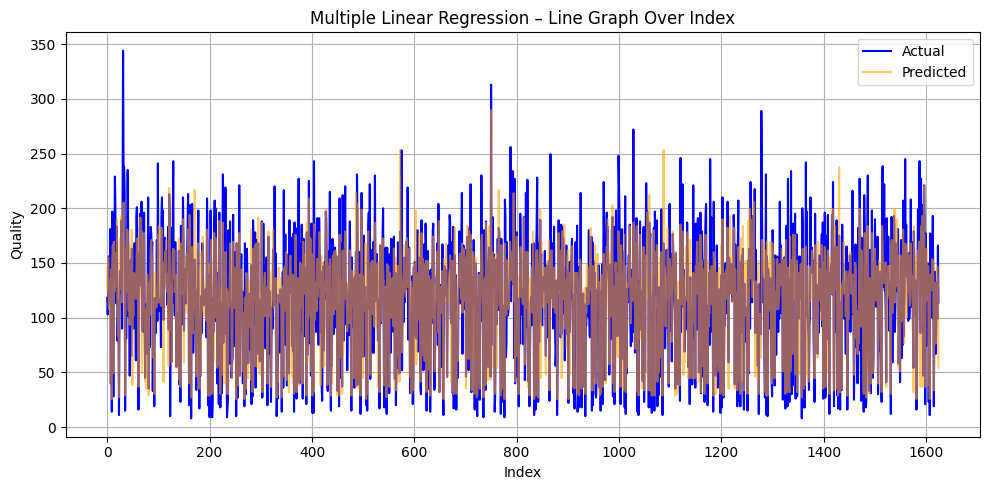

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(y_test)), y_test.values, color='blue', label='Actual')
plt.plot(np.arange(len(y_test)), y_pred, color='orange', alpha=0.6, label='Predicted')
plt.title('Multiple Linear Regression – Line Graph Over Index')
plt.xlabel('Index')
plt.ylabel('Quality')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Polynomial transformation (Degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_simple)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.25, random_state=42)

# Train model
model_poly = LinearRegression()
model_poly.fit(x_train, y_train)
y_pred = model_poly.predict(x_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print("📘 Polynomial Regression (Degree = 4) on 'residual sugar'")
print(f"R² Score: {r2:.4f}")
print(f"MSE     : {mse:.4f}")
print(f"RMSE    : {rmse:.4f}")
print(f"MAE     : {mae:.4f}")
print(f"MAPE    : {mape * 100:.2f}%")

📘 Polynomial Regression (Degree = 4) on 'residual sugar'
R² Score: 0.5367
MSE     : 1460.4923
RMSE    : 38.2164
MAE     : 30.1779
MAPE    : 46.27%


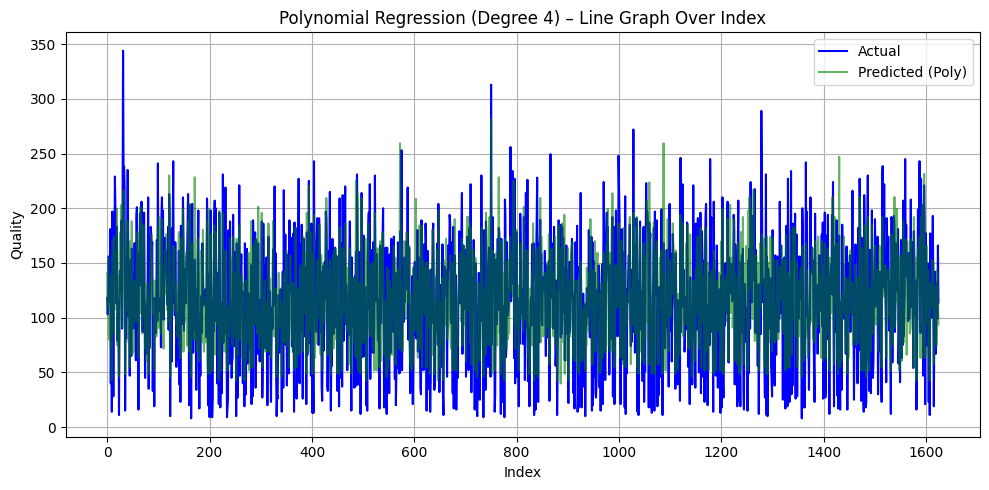

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(y_test)), y_test.values, color='blue', label='Actual')
plt.plot(np.arange(len(y_test)), y_pred, color='green', alpha=0.6, label='Predicted (Poly)')
plt.title('Polynomial Regression (Degree 4) – Line Graph Over Index')
plt.xlabel('Index')
plt.ylabel('Quality')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Simple Linear Regression
mse_simple = mse_simple
rmse_simple = rmse_simple
mape_simple = mape * 100  # already done in your code

# Multiple Linear Regression
mse_multi = mse
rmse_multi = rmse
mape_multi = mape * 100

# Polynomial Regression
mse_poly = mse
rmse_poly = rmse
mape_poly = mape * 100


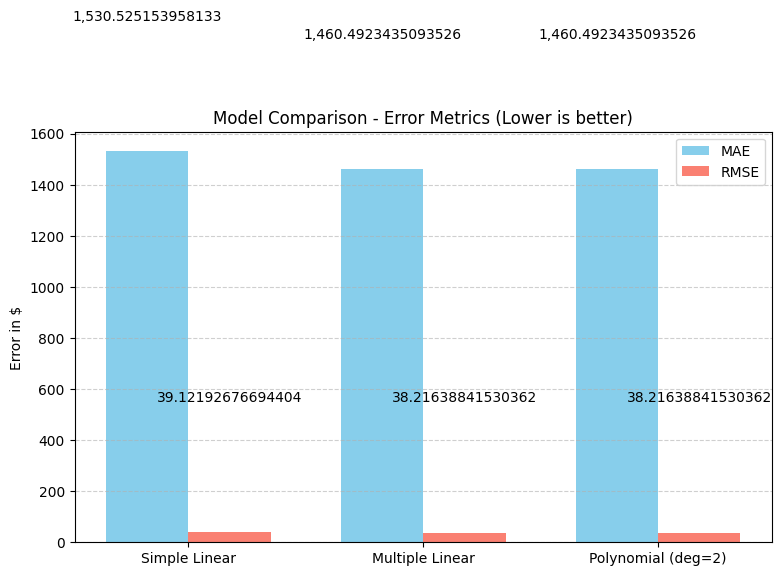

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Model labels
models = ['Simple Linear', 'Multiple Linear', 'Polynomial (deg=2)']

mae_values = [mse_simple, mse_multi, mse_poly]
rmse_values = [rmse_simple, rmse_multi, rmse_poly]


# Bar width and x-axis setup
x = np.arange(len(models))  # the label locations
bar_width = 0.35

# Plot
plt.figure(figsize=(8, 6))
plt.bar(x - bar_width/2, mae_values, bar_width, label='MAE', color='skyblue')
plt.bar(x + bar_width/2, rmse_values, bar_width, label='RMSE', color='salmon')

# Labels and formatting
plt.ylabel('Error in $')
plt.title('Model Comparison - Error Metrics (Lower is better)')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add text labels on top of bars
for i in range(len(models)):
    plt.text(x[i] - bar_width/2, mae_values[i] + 500, f'{mae_values[i]:,}', ha='center', va='bottom')
    plt.text(x[i] + bar_width/2, rmse_values[i] + 500, f'{rmse_values[i]:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()



K-Fold Split = 3
R2 Scores: [0.68077383 0.68727592 0.69173323]
Average R2 Score: 0.6865943251669394

K-Fold Split = 4
R2 Scores: [0.66916227 0.69224853 0.68557396 0.69808916]
Average R2 Score: 0.6862684813392239

K-Fold Split = 5
R2 Scores: [0.66353543 0.70785397 0.66775799 0.68911037 0.70023051]
Average R2 Score: 0.6856976529726626

K-Fold Split = 6
R2 Scores: [0.68002882 0.68128742 0.68202377 0.69246386 0.67643284 0.70448024]
Average R2 Score: 0.6861194922615824

K-Fold Split = 7
R2 Scores: [0.66379079 0.68818311 0.69287075 0.67299346 0.69011045 0.68676163
 0.70580211]
Average R2 Score: 0.6857874721459224

K-Fold Split = 8
R2 Scores: [0.66543022 0.6731175  0.7095599  0.6723599  0.67989955 0.69049438
 0.6817506  0.71079996]
Average R2 Score: 0.6854265013028811

K-Fold Split = 9
R2 Scores: [0.65560363 0.67486001 0.70707432 0.68776719 0.66563751 0.70804031
 0.67055974 0.68295684 0.71514943]
Average R2 Score: 0.6852943298205619

K-Fold Split = 10
R2 Scores: [0.65347752 0.67339885 0.7117

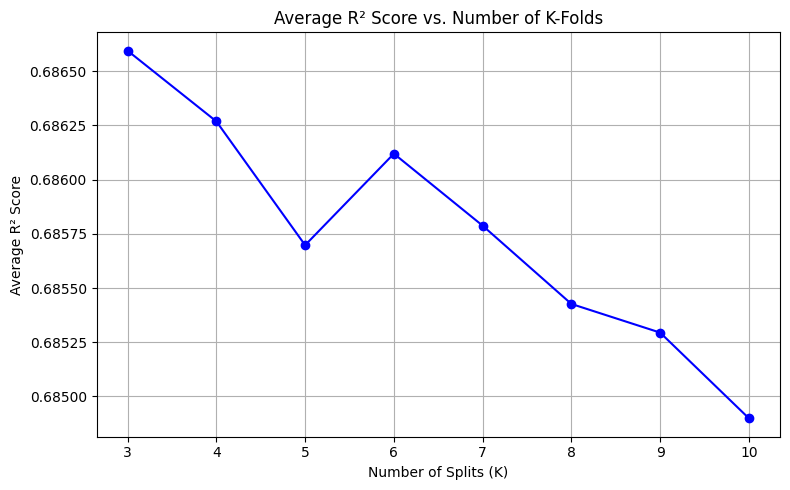

In [24]:


# Assuming X_multi and y are already defined
model_multi = LinearRegression()

# Store results
split_range = range(3, 11)
average_r2_scores = []

for n in split_range:
    kfold = KFold(n_splits=n, shuffle=True, random_state=42)
    scores = cross_val_score(model_multi, X_multi, y, cv=kfold, scoring='r2')
    average_score = scores.mean()
    average_r2_scores.append(average_score)
    
    # Print individual R2 scores
    print(f"\nK-Fold Split = {n}")
    print("R2 Scores:", scores)
    print("Average R2 Score:", average_score)

# Plotting the average R² scores
plt.figure(figsize=(8, 5))
plt.plot(split_range, average_r2_scores, marker='o', color='blue', linestyle='-')
plt.title('Average R² Score vs. Number of K-Folds')
plt.xlabel('Number of Splits (K)')
plt.ylabel('Average R² Score')
plt.grid(True)
plt.xticks(split_range)
plt.tight_layout()
plt.show()
